## Лабораторная работа 1: Алгоритмы разложения матриц. PCA.
### 1. Метод главных компонент
##### Cингулярное матричные разложения

In [1]:
#imports
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1234)

In [2]:
mtr = np.array([
    [0, 4, 8, 0, 5,],
    [10, -2, 28, -17, 0],
    [19, 19, 19, 7, -8],
    [43, 15, 23, 11, -14],
    [1, 2, 3, 4, 5,],
    [5, 4, 3, 2, 1],
    [12, 64, 7, 1, 0]
], dtype=np.double)
# U, S, V = SVD_updiag(house_bidiag(mtr)[1])
# U, S, V = SVD_updiag(mtr)

In [3]:
def norm(x: np.array):
  x = x.flatten()
  return np.sqrt(np.dot(x, x.T))


def proj(a, b):
  return (a.T @ b) / (b.T @ b) * b


def QR_GS(A: np.ndarray):
    """QR via Gram-Schmidt for any mxn matrix"""
    n, m = A.shape
    Q = np.zeros((n, m), dtype=np.double)
    R = np.zeros((m, m), dtype=np.double)
    Q[:, 0] = A[:, 0] / norm(A[:, 0])
    R[0, 0] = norm(A[:, 0])
    for i in range(1, m):
        Q[:, i] = A[:, i]
        for j in range(i):
            R[j, i] = Q[:, j].T @ Q[:, i]
            Q[:, i] -= R[j, i] * Q[:, j]
        R[i, i] = norm(Q[:, i])
        Q[:, i] /= norm(Q[:, i])
    return Q, R


def GSprocess(A):
    """Gram-Schmidt orthogonalization"""
    Q = np.zeros(A.shape, dtype=np.double)
    n = A.shape[1]
    for i in range(n):
        projs = np.zeros(n).T
        for j in range(i):
            projs -= proj(A[:, i], Q[:, j])
        projs += A[:, i]
        Q[:, i] = projs
    for i in range(n):
        Q[:, i] /= norm(Q[:, i])
    return Q

def house_v(a, eps=1e-12):
    """Generates the HH vector"""
    denom = (a[0] + norm(a) * (-1 if a[0] < 0 else 1))
    if abs(denom) > eps:
      v = a / denom
    else:
      v = np.zeros(a.shape)
    v[0] = 1
    tau = 2 / (v.T @ v)
    return v, tau

def QR(A, method='householder',):
  """ The case of m < n still to be considered"""
  m, n = A.shape
  if method == 'gram-schmidt':
    assert m == n, 'The square metrix is expected'
    Q = GSprocess(A)
    R = Q.T @ A
    return Q, np.triu(R)
  elif method == 'householder':
    R = A.copy()
    B = np.eye(m)
    Q = np.eye(m)
    for j in range(n):
      v, tau = house_v(R[j:, j, None])
      H = np.eye(m)
      H[j:, j:] -= tau * (v @ v.T)
      R = H @ R
      B = H @ B
      Q = H @ Q
    return Q.T, np.triu(R)
  else:
    raise Exception('Check whether this method exists. Or maybe we just have not implemented it...')



def house_bidiag(X):

    '''
    Transform A into the upper bidiagonal matrix through the Householder transformations

    In case the optimization is needed some methods are there:
    https://drsfenner.org/blog/2016/03/householder-bidiagonalization/
    '''
    A = X.copy()
    m, n = A.shape
    assert m >= n, "We expect the first dimension of the matrix to be not less than the second one"
    U, Vt = np.eye(m), np.eye(n)

    for j in range(n):
      v, tau = house_v(A[j:, j, None])
      H = np.eye(m)
      H[j:, j:] -= tau * np.outer(v, v)
      A[j:, j:] = H[j:, j:] @ A[j:, j:]
      U = U @ H
      if j <= n - 2:
        v, tau = house_v(A[j, j + 1:].T)
        # H = np.eye(m)
        # H[j + 1:, j + 1:] -= tau * (v @ v.T)
        H = np.eye(n)
        H[j + 1:, j + 1:] -= tau * np.outer(v, v)
        A[j:, j + 1:] = A[j:, j + 1:] @ H[j + 1:, j + 1:]
        Vt = H @ Vt

    return U, A, Vt # UAVt = initial A


def QR_algo(A, shift='simple', maxiter=10000, tol=1e-6):
  """
  QR iterations (optionally shifted)
  A = transform @ nxt @ transform.T
  """
  def wilkinsonShift(M):
        delta = (M[-2, -2] - M[-1, -1]) / 2
        shiftVal = M[-1, -1] - np.sign(delta) * M[-2, -1]**2 / (np.abs(delta) + math.sqrt(delta**2 + M[-2, -1]**2))
        return shiftVal
  d = 1.
  prev = np.copy(A)
  transform = np.eye(A.shape[0])
  while maxiter and d > tol:
    if shift == 'wilkinson':
      shift = wilkinsonShift(prev) * np.eye(prev.shape[0])
      Q, R = QR(prev - shift)
      nxt = R @ Q + shift
    elif shift == 'simple':
      sigma = prev[-1, -1]
      shift = sigma * np.eye(prev.shape[0])
      Q, R = QR(prev - shift)
      nxt = R @ Q + shift
    else:
      Q, R = QR(prev)
      nxt = R @ Q

    transform = transform @ np.copy(Q)
    d = np.max(np.abs(prev - nxt).flatten())
    prev = nxt
    maxiter -= 1
  return nxt, transform



# Проверка, что полученная матрица -- матрица собственных значений
# малое значение -- всё ок
def is_eigenvectors(m, T):
  # T = QR_algo_shift(m)[1]
  eigvs = m @ T / T
  return np.max(np.min(eigvs, axis=0) - np.max(eigvs, axis=0))




In [4]:
def QR_wilkinsonShift(H, maxiter=10000, tol=1e-10):

    def wilkinsonShift(M):
        delta = (M[-2, -2] - M[-1, -1]) / 2
        shiftVal = M[-1, -1] - np.sign(delta) * M[-2, -1]**2 / (np.abs(delta) + math.sqrt(delta**2 + M[-2, -1]**2))
        return shiftVal
    d = 1
    transform = np.eye(H.shape[0])
    prev = np.copy(H)

    while maxiter and d > tol:
      shift = wilkinsonShift(prev) * np.eye(prev.shape[0])
      Q, R = QR(prev - shift)
      transform = transform @ Q
      nxt = R @ Q + shift
      d = np.max(np.abs(prev - nxt).flatten())
      prev = nxt
      maxiter -= 1

    return nxt, transform


def SVD(X, tol=1e-10):
    m, n = X.shape
    mind = min(m, n)
    assert m >= n
    u, b, v = house_bidiag(X)
    s, left_trans = QR_algo(b @ b.T, tol=tol)
    s, right_trans = QR_algo(b.T @ b, tol=tol)
    s = np.diag(np.diag(s)) ** 0.5
    s = np.vstack([s, np.zeros((abs(m - n), mind))])

    tmp = np.diag(np.where((left_trans.T @ b @ right_trans).diagonal() < 0, -1, 1))
    signMatrix = np.zeros((m, m))
    signMatrix[:tmp.shape[0], :tmp.shape[1]] = tmp
    R = right_trans.T @ v
    # print(u.shape, left_trans.shape, signMatrix.shape)
    L = u  @ left_trans @ signMatrix
    return L, s, R

In [67]:
def PCA(X, n_components=2, centered=False, tol=1e-7, return_loadings=False):
  """returns principal components and covariance matrix eigenvalues"""
  assert 1 <= n_components <= X.shape[1]
  if not centered:
    means = X.mean(axis=0)
    stds = np.std(X, axis=0)
    X = (X - means) / stds
  U, S, Vt = SVD(X)
  L = np.diag(S) ** 2 / (X.shape[0] - 1)
  S = S[:, :n_components]
  if return_loadings:
    return U @ S, L[:n_components], Vt[:n_components, :].T
  return U @ S, L[:n_components]

def plot_variance(L):
  y = np.cumsum(L) / np.sum(L)
  plt.title('Cumulative explained variance')
  plt.ylabel('Proportion')
  plt.xlabel('Number of components')
  plt.plot(list(range(len(L) + 1)), [0] + list(y))
  plt.grid()
  plt.show()

# plot_variance(PCA(mtr, centered=False)[1])


##### Представление набора данных

In [7]:
#Information about dataset: https://www.kaggle.com/datasets/nareshbhat/wine-quality-binary-classification
!pip install ucimlrepo

In [8]:
from ucimlrepo import fetch_ucirepo

wine_quality = fetch_ucirepo(id=186)

n = 200
df = wine_quality.data.features
df['quality'] = (wine_quality.data.targets > 5).astype('int')
df = df.drop_duplicates()
Y = df['quality'][:n]
df = df.drop('quality', axis=1).to_numpy()[:n, :]

print(*[f'{k}: {v}' for k, v in wine_quality.metadata.items()], sep='\n')
print(wine_quality.variables)

uci_id: 186
name: Wine Quality
repository_url: https://archive.ics.uci.edu/dataset/186/wine+quality
data_url: https://archive.ics.uci.edu/static/public/186/data.csv
abstract: Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).
area: Business
tasks: ['Classification', 'Regression']
characteristics: ['Multivariate']
num_instances: 4898
num_features: 11
feature_types: ['Real']
demographics: []
target_col: ['quality']
index_col: None
has_missing_values: no
missing_values_symbol: None
year_of_dataset_creation: 2009
last_updated: Thu Aug 10 2023
dataset_doi: 10.24432/C56S3T
creators: ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis']
intro_paper: {'title': 'Modeling wine preferences by data mining from physicochemical properties', 'authors': 'P. Cortez, A. Cerdeira, Fernando Almeida, Telm

##### Применение метода сингулярного разложения на данных

In [ ]:
L, s , R = SVD(df)
# Three matrices give the original one being multiplied
assert np.max(L @ s @ R - df) < 1e-9

In [10]:
print('s = ', s)

#L and R are ORTHOGONAL
assert (L.T @ L - np.eye(L.shape[0])).max() < 1e-9
assert (R.T @ R - np.eye(R.shape[0])).max() < 1e-9
# s is diagonal
assert (np.vstack(
    [np.diag(np.diag(s)), np.zeros((s.shape[0] - s.shape[1], s.shape[1]))]
    ) - s).max() < 1e-9

s =  [[2252.53222684    0.            0.         ...    0.
     0.            0.        ]
 [   0.          159.57984715    0.         ...    0.
     0.            0.        ]
 [   0.            0.           68.5975647  ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


##### Преимущества и недостатки применения сингулярного и спектрального разложения к задачам PCA

Сингулярное разложение (SVD) и спектральное разложение (Eigendecomposition) - это два различных метода разложения матриц, которые могут быть применены к задачам метода главных компонент (PCA).

Преимущества применения SVD:
 1. Универсальность SVD. SVD может быть применено к любой матрице, не только квадратной, и оно всегда существует. Это делает его более универсальным для задач PCA;
 2. Эффективность. SVD может быть вычислено с помощью эффективных численных методов, таких как метод Голуба-Кахана;
 3. Работа с неполными данными. SVD может обрабатывать неполные или зашумленные данные, что полезно в реальных приложениях;
 4. Вычислительная стабильность. SVD обеспечивает более надежную и стабильную численную процедуру в сравнении с другими методами разложения, что делает его предпочтительным для работы с численно неустойчивыми матрицами;
 5. SVD может быть эффективно применено к разреженным данным, что важно в некоторых областях, например, для рекомендательных систем.

Недостатки применения SVD:
 1. Вычислительная сложность. SVD может быть вычислительно затратным для больших матриц;
 2. Ограничение размерности. В PCA с использованием SVD, вы можете выбирать только столько главных компонент, сколько есть признаков. Нельзя уменьшать размерность до определенного числа меньше исходного;
 3. Потеря интерпретируемости: Главные компоненты, полученные через SVD, не всегда имеют наглядную интерпретацию, так как они являются линейной комбинацией исходных признаков.

Преимущества применения спектрального разложения:
 1. Уменьшение размерности: Спектральное разложение позволяет уменьшить размерность данных до заданной целевой размерности;
 2. Интерпретируемость: Главные компоненты, полученные через спектральное разложение, могут быть более интерпретируемыми, так как они основаны на собственных векторах исходной матрицы.

Недостатки применения спектрального разложения:
 1. Ограничение квадратной матрицей: Спектральное разложение требует квадратной матрицы, что может быть недостаточно удобно в ряде задач;
 2. Вычислительная сложность: Прямое спектральное разложение может быть вычислительно сложным для больших матриц;
 3. Применимость только для квадратных матриц: Спектральное разложение возможно только для квадратных матриц, и в большинстве задач PCA исходная матрица не является квадратной.

##### Определение числа компонент, визуализация данных, анализ полученных компонент

Линейно разделимый датасет:
- Линейно разделимый датасет - это набор данных, в котором классы можно идеально разделить с помощью линейной разделяющей гиперплоскости. Это означает, что существует прямая линия (в двумерном пространстве), или гиперплоскость (в многомерном пространстве), которая может точно отделить один класс от другого без ошибок.
- Для линейно разделимого датасета можно использовать простые методы классификации, такие как метод опорных векторов (SVM) или логистическая регрессия, чтобы построить оптимальную линейную разделяющую гиперплоскость.
- Линейно разделимые данные находят широкое применение в областях, где классификация является относительно простой задачей. Например, это может быть задачей, связанной с распознаванием образов на изображениях, где объекты имеют четкие границы и хорошо разделяются.
- В случае линейно разделимых данных алгоритмы классификации, как правило, достигают высокой точности и хорошо обобщаются на новые данные. Это может быть следствием хорошей обоснованности данных или простоты задачи.
Неразделимый датасет:
- Неразделимый датасет - это набор данных, в котором классы или категории имеют перекрывающиеся области или нет четкой линейной разделяющей гиперплоскости. Это означает, что нет идеального способа разделить классы с нулевой ошибкой.
- Для неразделимого датасета может потребоваться использование более сложных методов классификации, таких как методы с ядрами (например, SVM с ядровыми функциями) или методы глубокого обучения с нелинейными архитектурами нейронных сетей.
- Неразделимые данные часто возникают в реальных задачах, где объекты имеют сложные и перекрывающиеся признаки. Примерами могут служить задачи распознавания рукописного текста или анализа медицинских изображений.
- В случае неразделимых данных важно оценить, насколько сложно их классифицировать, и выбрать подходящий метод, способный учитывать перекрывающиеся области. Алгоритмы, способные обрабатывать неразделимые данные, могут иметь более высокую сложность и требовать большего объема данных для обучения, чтобы избежать переобучения.



#### Применение РСА
Чтобы оценить значимость переменных, проведём центрирование и масштабирование признаков, установив флаг centered=False.



<ipython-input-3-bc8593994699>:121: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if shift == 'wilkinson':
<ipython-input-3-bc8593994699>:125: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif shift == 'simple':


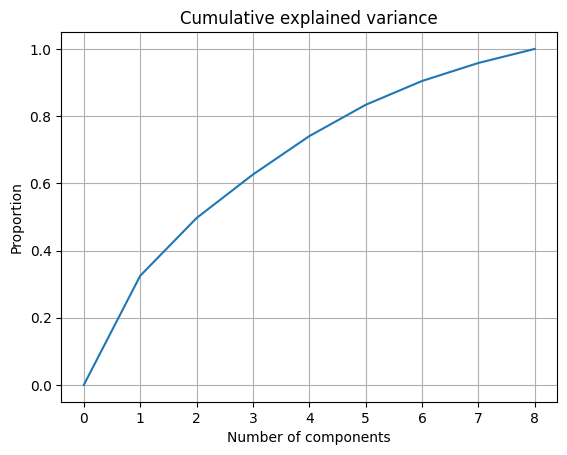

In [90]:
trans, L, loadings = PCA(df, n_components=8, return_loadings=True)
plot_variance(L)

Как можно заметить из графика, 5 компонент объясняют более 80 % дисперсии, так что это является хорошим выбором.

Теперь посмотрим как выглядят данные в новых координатах первых трех главных компонент:

In [96]:
loadings.shape

(11, 8)

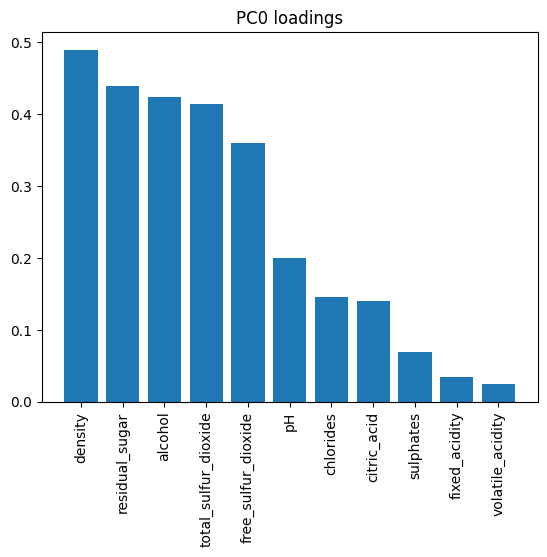

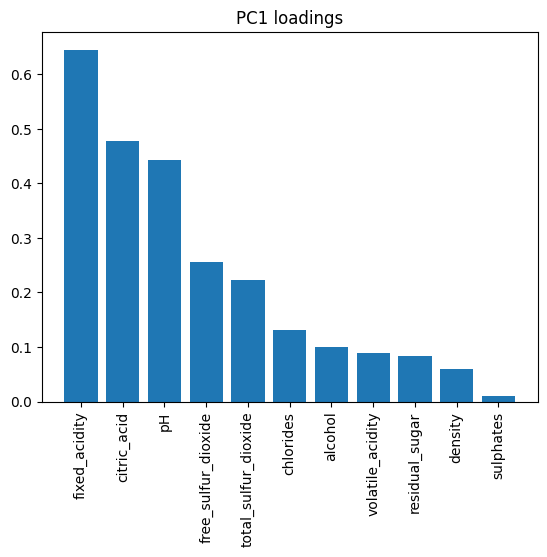

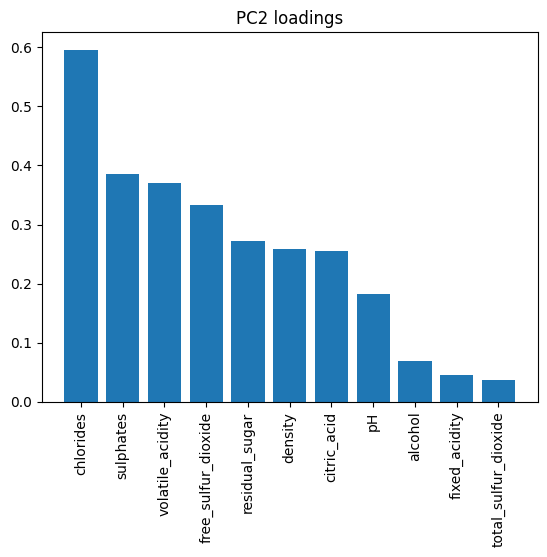

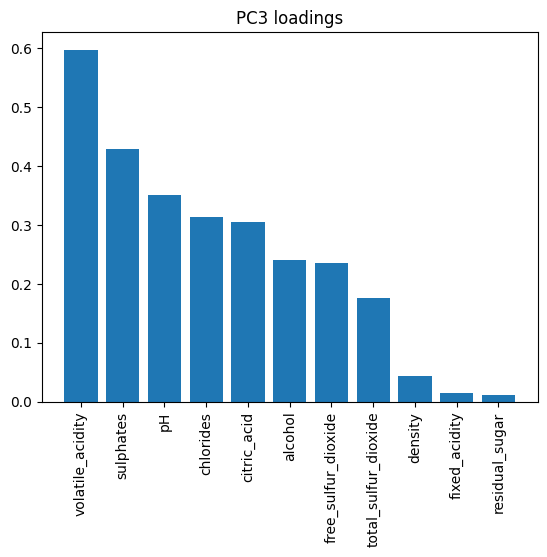

In [100]:
features = wine_quality.data.features.columns[:-1]
for i in range(4):
  absvals = np.abs(loadings[:, i])
  args = np.flip(np.argsort(absvals))
  plt.bar(features[args], absvals[args])
  plt.xticks(rotation=90)
  plt.title(f'PC{i} loadings')
  plt.show()

Проанализировав диаграммы нагрузок можно сказать, что в наибольшей степени за нулевую компоненту отвечает (внезапно!) плотность и  легко органолептически различимые показатели, как сахаристость и алкогольность. Для более детального анализа именно вкусовых акцентов желательно рассмотреть более дальние компоненты, например, PC2 и PC3, поскольку они в наибольшей степени отражают состав с точки зрения летучих соединений и растворимых солей, ответственных за вкус.

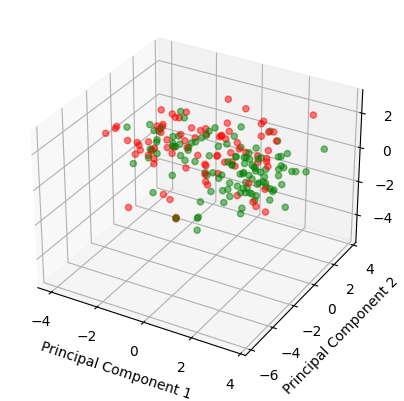

In [12]:
x, y, z = trans[:, :3].T
colors = Y.map({0: 'r', 1: 'g'})
f = plt.figure()
ax = f.add_subplot(projection='3d')
ax.scatter(x, y, z, color=colors, alpha=0.5)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()

##### Дополнительное задание

In [78]:
def RPCA(X, n_components=2, centered=False, return_loadings=False):
  """Halko, N., Martinsson, P. G., & Tropp, J. A. (2011).
  Finding Structure with Randomness: Probabilistic Algorithms for Constructing Approximate Matrix Decompositions.
  SIAM Review, 53(2), 217–288. doi:10.1137/090771806 """
  assert 1 <= n_components <= X.shape[1]
  if not centered:
    means = X.mean(axis=0)
    stds = np.std(X, axis=0)
    X = (X - means) / stds
  U, S, Vt = RSVD(X, n_components)
  L = np.diag(S) ** 2 / (X.shape[0] - 1)
  S = S[:, :n_components]
  if return_loadings:
    return U @ S,  L[:n_components], Vt #[:n_components, :].T
  return U @ S, L

def FRRF(A, k):
  def R(n, k):
    indices = np.random.randint(0, n, size=k)
    indices = np.sort(indices)
    return np.eye(n)[:, indices]

  def F(n):
    res = np.zeros((n, n), dtype=np.double)
    for i in range(n):
      for j in range(n):
        res[i, j] = 1 / np.sqrt(n)  * np.exp(-2 * np.pi * 1j * i * j / n)
    return res.real
  m, n = A.shape
  return np.sqrt(
      n / k ) * np.diag(np.random.randn(n)) @ F(n) @ R(n, k)

def RSVD(A, k):

    Y = A @ FRRF(A, k)
    Q = QR(Y)[0]

    B = Q.T @ A
    U, S, Vt = SVD(B)
    U = Q @ U

    U, S, Vt = U[:, :k], S[:k, :k], Vt[:k, :]

    return U, S, Vt

#####Сравним результаты разложения RSVD и реализацией из библиотеки scikit-learn

In [ ]:
from sklearn.decomposition import PCA as sklPCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
scaler = StandardScaler()
data = scaler.fit_transform(df)
data = SimpleImputer(fill_value=0).fit_transform(data)

skl = sklPCA(2).fit_transform(data)
r = RPCA(data, 2)[0]


Text(0.5, 1.0, "sklearn's PCA")

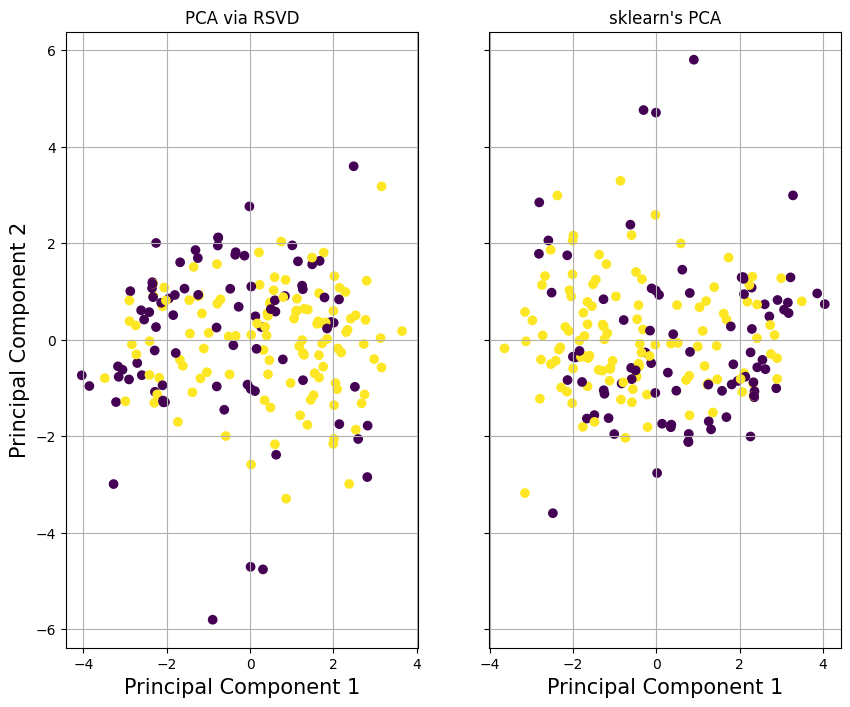

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8), sharey=True)
n = None
ax1 = axes[0]
ax2 = axes[1]
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.scatter(r[:n, 0], r[:n, 1], c=Y, alpha=1)
ax1.grid()
ax1.set_title('PCA via RSVD')

ax2.set_xlabel('Principal Component 1', fontsize = 15)
ax2.scatter(skl[:n, 0], skl[:n, 1], c=Y, alpha=1)
ax2.grid()
ax2.set_title(f'sklearn\'s PCA')

Как можно заметить, полученные данные идентичны с точностью до знака

### 2. Kernel PCA

##### Представление набора данных

In [ ]:
!pip install ucimlrepo

In [164]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=27)

n = min(df.data.features.shape[0], 600)
data = df.data.features.dropna(inplace=False)
data = data.drop_duplicates()
data = data[data.columns[data.dtypes != 'object']]
indices = np.random.randint(0, data.shape[0], size=n)
# print(indices)
data = data.iloc[indices, :]

y = (df.data.targets.loc[data.index, 'A16'] == '+').astype(int)


print(*[f'{k}: {v}' for k, v in df.metadata.items()], sep='\n')
print(df.variables)


uci_id: 27
name: Credit Approval
repository_url: https://archive.ics.uci.edu/dataset/27/credit+approval
data_url: https://archive.ics.uci.edu/static/public/27/data.csv
abstract: This data concerns credit card applications; good mix of attributes
area: Business
tasks: ['Classification']
characteristics: ['Multivariate']
num_instances: 690
num_features: 15
feature_types: ['Categorical', 'Integer', 'Real']
demographics: []
target_col: ['A16']
index_col: None
has_missing_values: yes
missing_values_symbol: NaN
year_of_dataset_creation: 1987
last_updated: Wed Aug 23 2023
dataset_doi: 10.24432/C5FS30
creators: ['J. R. Quinlan']
intro_paper: None
additional_info: {'summary': 'This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.\r\n  \r\nThis dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers o

*Среди* имеющихся фичей оставили некатегориальные:

In [166]:
data.head()

,A15,A14,A11,A8,A3,A2
82,0,288.0,0,0.25,0.500,39.83
25,0,100.0,2,1.50,0.585,15.83
525,0,140.0,0,2.50,1.500,45.17
101,0,80.0,0,4.00,16.500,35.25
318,1,500.0,0,0.00,0.000,19.17


In [169]:
# from sklearn.decomposition import PCA as sklPCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
scaler = StandardScaler().fit(data)
data = scaler.transform(data)
data = SimpleImputer(fill_value=0).fit_transform(data)

trans = RPCA(data)[0]
# trans = sklPCA().fit_transform(data)



Распределение объектов в пространстве признаков является достаточно сложным в визуализации. Когда же речь заходит о такой категории, как  линейная разделимость, визуальный анализ перестаёт быть функционирующим в силу возможного наложения кластеров данных в их двумерных проекциях.
По этой причине необходимо ввести некоторую количественную характеристику линейной разделимости.

В заметке https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.121.6481&rep=rep1&type=pdf

рассматриваются несколько возможных решений данной задачи.

Мы выбрали метод, основанный на методе опорных векторов с линейным ядром. За счёт большой регуляризационной константы C мы смещаем интерес алгоритма в сторону уменьшения количества нарушителей. Итоговая оценка считается как accuracy предсказания классификатора на обучающей выборке. В случае результата 1.0 существует гиперплоскость, разделившая два класса полность.

In [28]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
def is_lin_separable(X, y):
  return np.round(accuracy_score(y, SVC(C=1<<20, kernel='linear', max_iter=10000).fit(X, y).predict(X)), 2)


#####начальная разделимость:

In [147]:
# Initial separability
is_lin_separable(trans[:, :2], y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.38

##### Реализация методов вычисления матрицы для различных ядер  и её последующего спектрального разложения

In [149]:
def getStandardizedData(M: np.ndarray) -> np.ndarray:
    """ Returns standardized data (A - A.mean) / A.std"""
    return (M - M.mean(axis=0)) / M.std(axis=0)

def center(K):
  n = K.shape[0]
  H = np.eye(n) - 1 / n * np.ones((n, n))
  return H @ K @ H

def center(K: np.ndarray):
    A = np.eye(K.shape[0]) - np.ones(K.shape) / K.shape[0]
    return np.dot(np.dot(A, K), A)

def poly(M: np.ndarray, degree=3, coef=1) -> np.ndarray:
    K = (coef + np.dot(M.T, M))**degree
    return K


def rbf(M: np.ndarray, gamma=1.0) -> np.ndarray:
    K = np.exp(-gamma * np.sum((M.T - M.T[:, np.newaxis])**2, axis = -1))
    return K


def sigmoid(M: np.ndarray, gamma=1.0, coef=1) -> np.ndarray:
    K = np.tanh(gamma * np.dot(M.T, M) + coef)
    return K


def kernelPCA(data: np.ndarray, kernel="poly", n_components=2, degree=2, gamma=1.0, coef=1):
    """Standardizes data, applies kernel, returns principal components and partition of variance"""
    data = getStandardizedData(data)
    if kernel == "poly":
        K = poly(data, degree, coef)
    elif kernel == "rbf":
        K = rbf(data, gamma)
    elif kernel == "sigmoid":
        K = sigmoid(data, gamma, coef)
    else:
        raise Exception('Kernel "' + kernel + '" does not exist!')

    K = center(K)
    eigenvalues, eigenvectors = QR_wilkinsonShift(K)
    eigenvalues = eigenvalues.diagonal()

    count = 0
    sortedInd = np.flip(eigenvalues.argsort())
    newBasis = np.zeros((n_components, K.shape[0]))
    partVariance = 0
    totalVariance = eigenvalues.sum()
    for ind in sortedInd:
        if count == n_components:
            break
        else:
            newBasis[count, :] = eigenvectors[ind, :]
            partVariance += eigenvalues[ind] / totalVariance
            count += 1

    return data @ newBasis.T, partVariance

Небольшой перебор параметров, чтобы подобрать лучшие для ядра:

In [150]:
def grid(X, y, params, min_max_n_pc=(2, 3)):
  if isinstance(X, pd.DataFrame):
    X = X.to_numpy()

  res = pd.DataFrame(columns=['kernel', 'n_components', 'coef', 'gamma', 'degree', 'val'])
  k = 0
  min_n_pc, max_n_pc = min_max_n_pc
  for i, (krn, coef, gamma, degree) in enumerate(params):
     PCs, partVariance= kernelPCA(X, kernel=krn,
                             gamma=gamma,
                             coef=coef, degree=degree, n_components=max_n_pc)
     for j in range(min_n_pc, max_n_pc + 1):
        val = is_lin_separable(PCs[:, :j], y)
        res.loc[k] = (krn, j, coef, gamma, degree, val)
        k += 1
  return res

from itertools import product

params = product(
    ['sigmoid', 'rbf'],
    [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    [1]
)


In [ ]:
res_rbf_sigm = grid(data, y, params, (2, 4))
res_poly = grid(data, y,
                 product(
    ['poly'],
    [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    [0],
    [ 2, 3, 4, 5]
),
                 (2, 4)
                 )

In [154]:
top_params = res_poly[res_poly.n_components == 2].sort_values(['val'], ascending=False).head()
top_params = pd.concat([top_params, res_rbf_sigm[(res_rbf_sigm.n_components == 2)].sort_values(['val'], ascending=False).head()], axis=0)
top_params

,kernel,n_components,coef,gamma,degree,val
87,poly,2,100.0,0.000,3,0.69
81,poly,2,1.0,0.000,5,0.68
78,poly,2,1.0,0.000,4,0.68
66,poly,2,0.1,0.000,4,0.65
93,poly,2,100.0,0.000,5,0.63
84,rbf,2,1000.0,0.010,1,0.68
114,rbf,2,10000.0,0.010,1,0.68
81,rbf,2,1000.0,0.001,1,0.68
54,rbf,2,100.0,0.010,1,0.68
51,rbf,2,100.0,0.001,1,0.68


In [155]:
best_params = dict(top_params.sort_values(['val'], ascending=False).iloc[0])
print('Best score:', best_params['val'])
del best_params['val']
best_params

Best score: 0.69


{'kernel': 'poly', 'n_components': 2, 'coef': 100.0, 'gamma': 0.0, 'degree': 3}

##### Сравнительный анализ применения PCA и Kernel PCA

Text(0.5, 1.0, 'Kernel PCA')

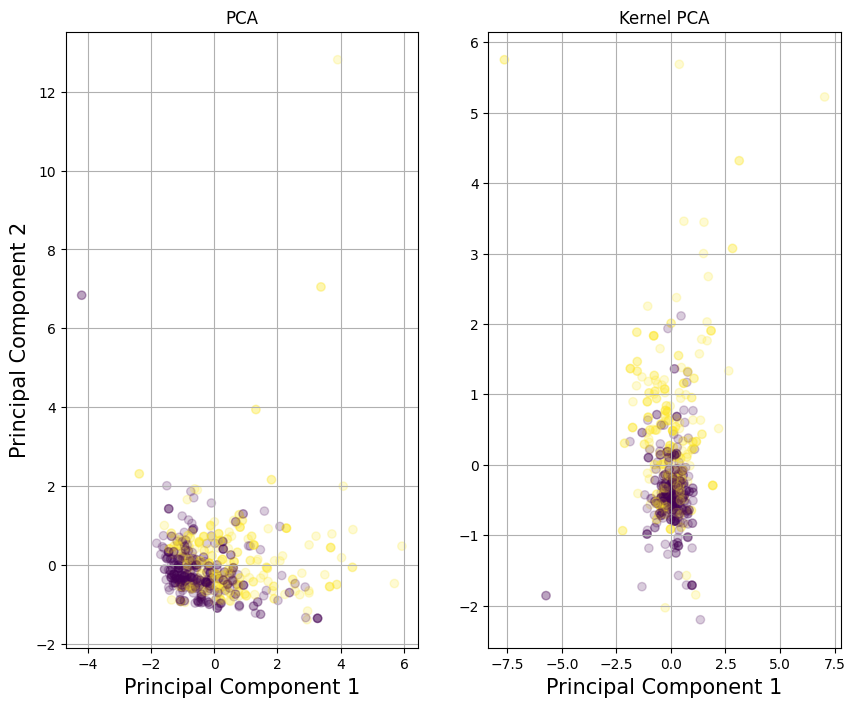

In [158]:
fig, axes = plt.subplots(1, 2, figsize=(10, 8))
n = None
ax1 = axes[0]
ax2 = axes[1]
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.scatter(trans[:n, 0], trans[:n, 1], c=y[:n], alpha=0.2)
ax1.grid()
ax1.set_title('PCA')

ktrans = kernelPCA(data, **best_params)[0]
ax2.set_xlabel('Principal Component 1', fontsize = 15)
# ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax2.scatter(ktrans[:n, 0], ktrans[:n, 1], c=y[:n], alpha=.2)
ax2.grid()
ax2.set_title(f'Kernel PCA')

Как можно заметить, хотя kernel PCA и не позволило достичь полной разделимости данных, метрика is_lin_separable выросла от 38% до 69%

Сравним влияние различных ядер:

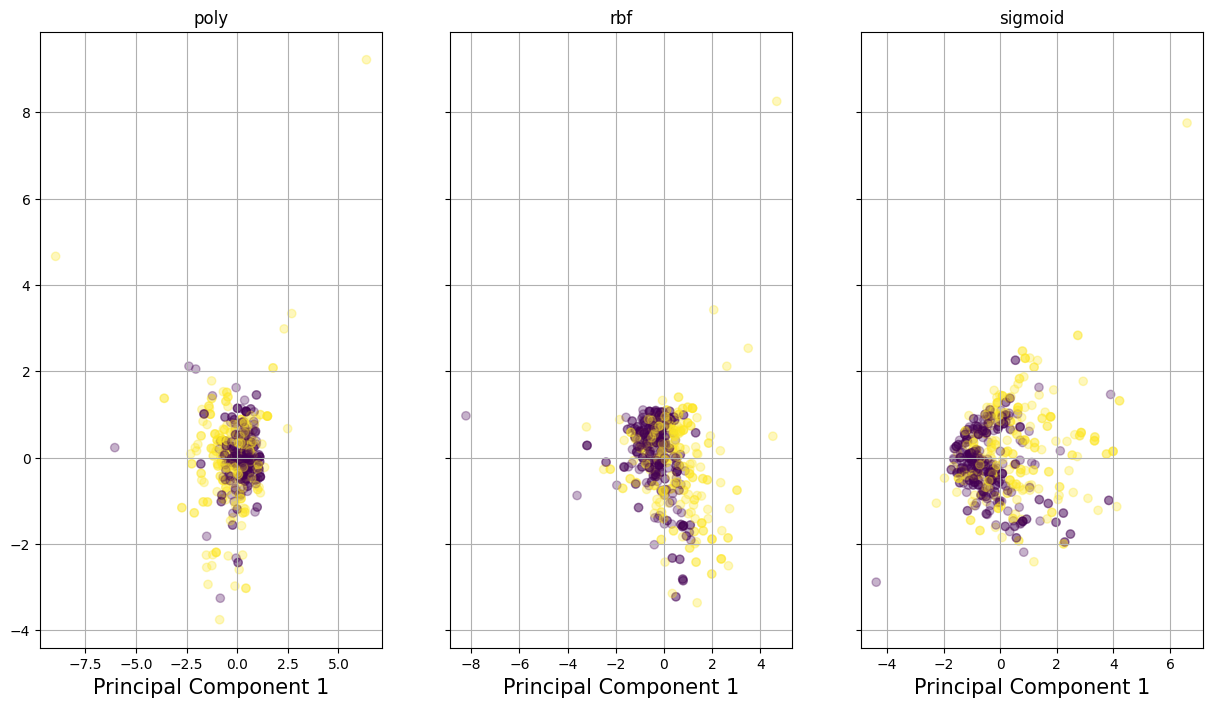

In [177]:
krns = [
    {'kernel': 'poly', 'n_components': 2, 'coef': 100.0, 'gamma': 0.0, 'degree': 3},
    {'kernel': 'rbf', 'n_components': 2, 'coef': 1000.0, 'gamma': 0.10, 'degree': 1},
    {'kernel': 'sigmoid', 'n_components': 2, 'coef': 10.0, 'gamma': 0.10, 'degree': 1},
]


fig, axes = plt.subplots(1, 3, sharey=True)
fig.set_size_inches((15, 8))
for i, krn in enumerate(krns):
  ktrans = kernelPCA(data, **krn)[0]
  ax = axes[i]
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  # ax1.set_ylabel('Principal Component 2', fontsize = 15)
  ax.scatter(ktrans[:n, 0], ktrans[:n, 1], c=y[:n], alpha=.3)
  ax.grid()
  ax.set_title(krn['kernel'])


Резльтаты применения различных ядер показали, что все ядра растягивают кластеры по периферии и влияние более заметно для жёлтых объектов, однако для sigmoid характерно растягивание обоих кластеров.

Линейность и нелинейность:

 • PCA является линейным методом и предполагает, что главные компоненты являются линейными комбинациями исходных признаков. Он хорошо подходит для данных, которые могут быть разделены линейными гиперплоскостями.
 • Kernel PCA является нелинейным методом. Он может обрабатывать данные, которые не могут быть эффективно разделены линейными методами. Kernel PCA использует ядерные функции (например, полиномиальные, RBF) для преобразования данных в более высокоразмерное пространство, где они могут быть линейно разделены.

Уменьшение размерности:

 • PCA стремится к поиску главных компонент, которые максимизируют дисперсию данных в ортогональных направлениях. Это приводит к линейной комбинации исходных признаков.
 • Kernel PCA также уменьшает размерность, но может создавать нелинейные комбинации признаков, что делает его мощным инструментом для работы с нелинейными данными.

Вычислительная сложность:

 • PCA имеет линейную вычислительную сложность и хорошо масштабируется для больших наборов данных.
 • Kernel PCA может быть вычислительно более сложным, особенно если используется высокоразмерное пространство, созданное ядерной функцией. Вычислительная сложность может быстро расти с увеличением размерности.

Интерпретация:

 • PCA генерирует новые признаки, которые являются линейными комбинациями исходных признаков. Интерпретация главных компонент обычно менее интуитивна.
 • Kernel PCA создает нелинейные комбинации признаков, что может усложнить интерпретацию результатов.